In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import base64

In [2]:
from ultralytics import YOLO

In [3]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolo11n.pt")

In [4]:
def zero_padding(img: np.ndarray, padding: int) -> np.ndarray:
    """
    Apply zero padding to the image.
    
    Args:
        img (numpy.ndarray): Input image.
        padding (int): Amount of padding to add to each side.
        
    Returns:
        numpy.ndarray: Padded image.
    """
    # Get the shape of the original image
    h, w, c = img.shape

    # Calculate the new dimensions with padding
    new_h = h + 2 * padding
    new_w = w + 2 * padding

    # Create a new image with the new dimensions
    # padded_img = cv2.resize(img, (new_w, new_h))
    # # Fill the new image with zeros (black)
    # padded_img.fill(0)
    padded_img = np.zeros((new_h, new_w, c), dtype=np.uint8)


    # Copy the original image into the center of the new image
    padded_img[padding:padding + h, padding:padding + w] = img
    return padded_img

In [5]:
def resize(img: np.ndarray, new_size: tuple) -> np.ndarray:
    """
    Resize the image to the new size.
    
    Args:
        img (numpy.ndarray): Input image.
        new_size (tuple): New size (width, height).
        
    Returns:
        numpy.ndarray: Resized image.
    """
    # Get the original dimensions
    original_height, original_width = img.shape[:2]
    new_width, new_height = new_size

    # Create an empty array for the resized image
    resized_img = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)

    # Calculate the scaling factors
    scale_x = original_width / new_width
    scale_y = original_height / new_height

    # Map each pixel in the new image to the corresponding pixel in the original image
    for y in range(new_height):
        for x in range(new_width):
            # Find the corresponding pixel in the original image
            orig_x = int(x * scale_x)
            orig_y = int(y * scale_y)

            # Ensure indices are within bounds
            orig_x = min(orig_x, original_width - 1)
            orig_y = min(orig_y, original_height - 1)

            # Assign the pixel value
            resized_img[y, x] = img[orig_y, orig_x]

    return resized_img

In [6]:
def apply_gaussian_blur(img: np.ndarray, kernel_size: tuple, sigma: float = 1.0) -> np.ndarray:
    """
    Apply Gaussian blur to the image without using cv2.GaussianBlur.

    Args:
        img (numpy.ndarray): Input image.
        kernel_size (tuple): Size of the Gaussian kernel (width, height).
        sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
        numpy.ndarray: Blurred image.
    """
    if sigma <= 0:
        raise ValueError("Sigma must be a positive, non-zero value.")

    # Generate a Gaussian kernel
    kx, ky = kernel_size
    ax = np.linspace(-(kx // 2), kx // 2, kx)
    ay = np.linspace(-(ky // 2), ky // 2, ky)
    xx, yy = np.meshgrid(ax, ay)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)  # Normalize the kernel

    # Handle cases where the kernel contains NaN or inf values
    if np.isnan(kernel).any() or np.isinf(kernel).any():
        raise ValueError("Invalid kernel generated. Check the sigma and kernel size.")

    # Pad the image to handle borders
    pad_x, pad_y = kx // 2, ky // 2
    padded_img = np.pad(img, ((pad_y, pad_y), (pad_x, pad_x), (0, 0)), mode='reflect')

    # Apply the Gaussian kernel to each channel
    blurred_img = np.zeros_like(img)
    for c in range(img.shape[2]):  # Loop over color channels
        for i in range(img.shape[0]):  # Loop over rows
            for j in range(img.shape[1]):  # Loop over columns
                region = padded_img[i:i + ky, j:j + kx, c]
                blurred_img[i, j, c] = np.sum(region * kernel)

    return blurred_img

In [7]:
def extract_people(img: np.ndarray, file_extension: str) -> list:
    """
    Extract Individual people from an image usign YOLO model

    Args:
        img (numpy.ndarray): Input image.
        file_extension (str): File extension for the output images.
    
    Returns:
        list: List of base64 encoded images of individual persons.
    """
    # Preprocessing
    # img = cv2.resize(img, (640, 640))  # Resize to YOLO's input size
    img = resize(img, (640, 640))  # Resize to YOLO's input size
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    # img = cv2.GaussianBlur(img, (5, 5), 0)  # Denoise
    img = apply_gaussian_blur(img, (5, 5))  # Denoise

        # Perform inference on the image
    results = model.predict(source=img, conf=0.5)
    # Filter results to only include persons (class ID 0)
    person_detections = [box for box in results[0].boxes if box.cls == 0]

    offset = 50
    # Display individual extracted people
    persons = []
    for box in person_detections:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        x1 = max(0, x1 - offset)
        y1 = max(0, y1 - offset)
        x2 = min(img.shape[1], x2 + offset)
        y2 = min(img.shape[0], y2 + offset)
        person_image = img[y1:y2, x1:x2]
        person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(person_image)
        plt.axis('off')
        plt.show()

        _, buffer = cv2.imencode(file_extension, person_image)
        person_image_base64 = base64.b64encode(buffer).decode()
        persons.append(person_image_base64)
    
    return persons


0: 640x640 5 persons, 246.7ms
Speed: 6.9ms preprocess, 246.7ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 640)


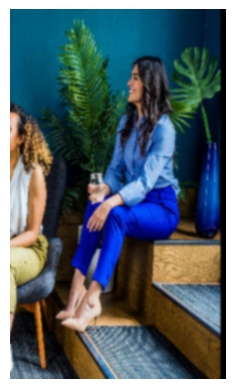

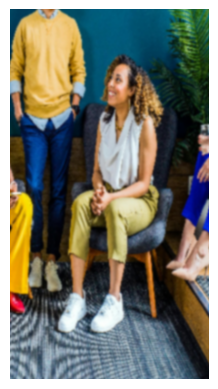

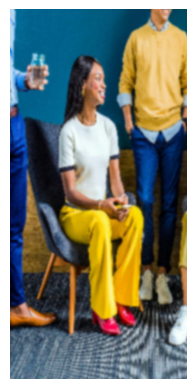

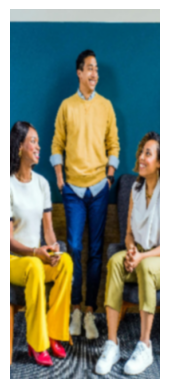

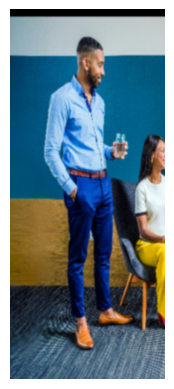

5


In [8]:
img = cv2.imread("people.jpg")
file_extension = ".jpg"
padded = zero_padding(img, 50)
persons = extract_people(padded, file_extension)
print(len(persons))